In [ ]:
# Cloning the FSOD repository from "Frustratingly Simple Object Detection" paper and navigating to repo #test
!git clone https://github.com/idriswardere/fsod-valorant.git
%cd fsod-valorant
%ls

Cloning into 'fsod-valorant'...
remote: Enumerating objects: 907, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 907 (delta 323), reused 333 (delta 300), pack-reused 449
Receiving objects: 100% (907/907), 8.79 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (522/522), done.
/content/fsod-valorant
configs/   fsdet/              pyproject.toml        tools/
datasets/  FSOD_Project.ipynb  README.md*            valorant-fsod.ipynb
demo/      fsod-valorant/      requirements-dev.txt
docs/      LICENSE*            requirements.txt*


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Installing Detectron2 and other requirements
!pip install git+https://github.com/facebookresearch/detectron2
!python3 -m pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2 to /tmp/pip-req-build-gqom71le
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2 /tmp/pip-req-build-gqom71le
  Resolved https://github.com/facebookresearch/detectron2 to commit ecb786ccd26de4086a6fede437e7d728199470e2
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import critical libraries
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Downloading our custom dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="GMQT8YWluuOVof5f1Jnk")
project = rf.workspace("fsodvalorant").project("fsod-valorant")
dataset = project.version(4).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to FSOD-Valorant-4 in coco:: 100%|██████████| 206/206 [00:00<00:00, 1361.49it/s]


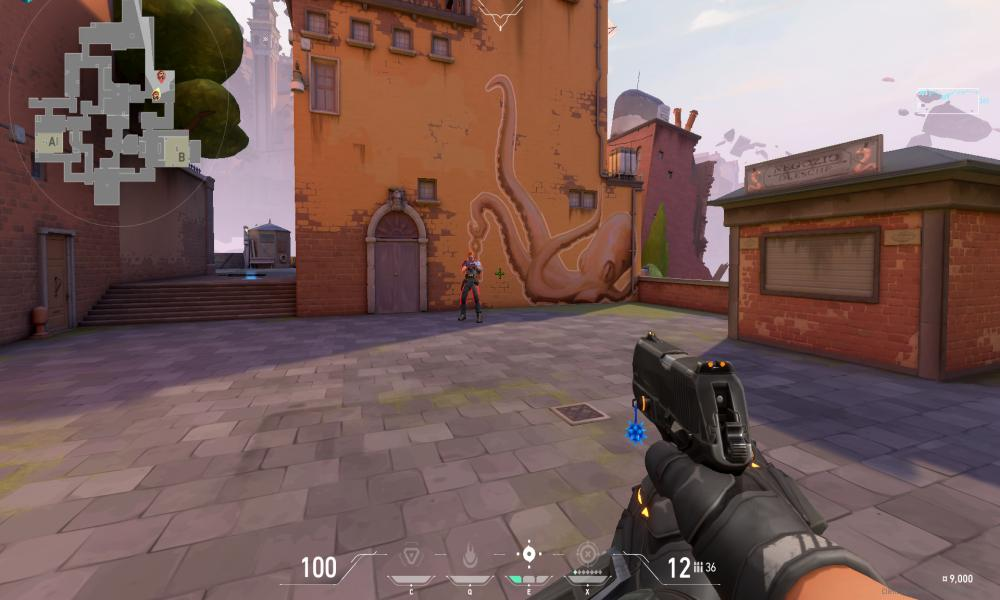

In [ ]:
# Show a random image from the custom Valorant dataset
img_path = "FSOD-Valorant-4/test/Valorant-Screenshot-2023-03-27-22-22-15-80_png.rf.94bb19bd9c85c61e109488d5a7b6e8fa.jpg"

im = cv2.imread(img_path)
cv2_imshow(im)

In [ ]:
# Setting up a base model predictor and making prediction

config_file_name = "configs/PascalVOC-detection/split1/faster_rcnn_R_101_FPN_base1.yaml"
checkpoint_url_name = "http://dl.yf.io/fs-det/models/voc/split1/base_model/model_final.pth"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Making config
cfg = get_cfg()
cfg.merge_from_file(config_file_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.DEVICE = DEVICE
# Feel free to find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = checkpoint_url_name
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/26 04:04:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from http://dl.yf.io/fs-det/models/voc/split1/base_model/model_final.pth ...


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([10], device='cuda:0')
Boxes(tensor([[454.7667, 249.9657, 489.0134, 321.2336]], device='cuda:0'))


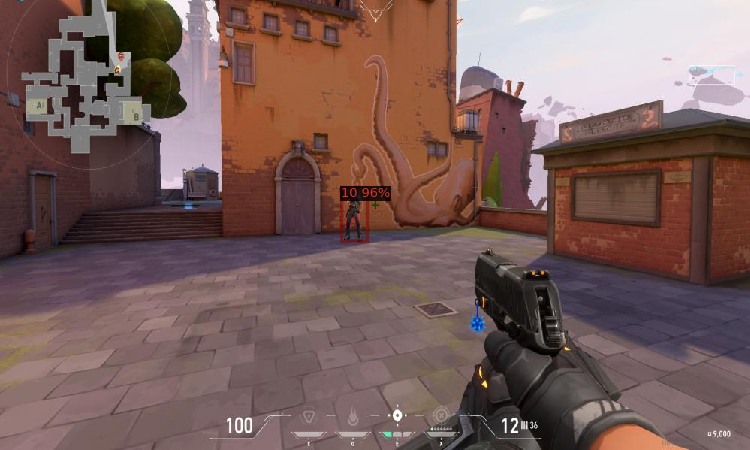

In [ ]:
# We can use `Visualizer` to draw the predictions from the base model on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.75)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Registering custom dataset

from detectron2.data.datasets import register_coco_instances

train_valorant_dataset = 'fsod-valorant-4-train'
valid_valorant_dataset = 'fsod-valorant-4-test'

register_coco_instances(train_valorant_dataset, {}, "FSOD-Valorant-4/train/_annotations.coco.json", "FSOD-Valorant-4/train")
register_coco_instances(valid_valorant_dataset, {}, "FSOD-Valorant-4/test/_annotations.coco.json", "FSOD-Valorant-4/test")

In [ ]:
# Creating dataloader from custom dataset

from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
#print("!!!", cfg)
batch_size = 1
train_dl = build_detection_train_loader(DatasetCatalog.get(train_valorant_dataset), mapper=DatasetMapper(cfg, is_train=True), total_batch_size=batch_size)
valid_dl = build_detection_train_loader(DatasetCatalog.get(valid_valorant_dataset), mapper=DatasetMapper(cfg, is_train=True, augmentations=[]), total_batch_size=batch_size)

!!! CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('fsod-valorant-4-test',)
  TRAIN: ('fsod-valorant-4-train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE: False
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVIC

Instances(num_instances=1, image_height=736, image_width=1227, fields=[gt_boxes: Boxes(tensor([[668., 290., 692., 339.]])), gt_classes: tensor([6])])


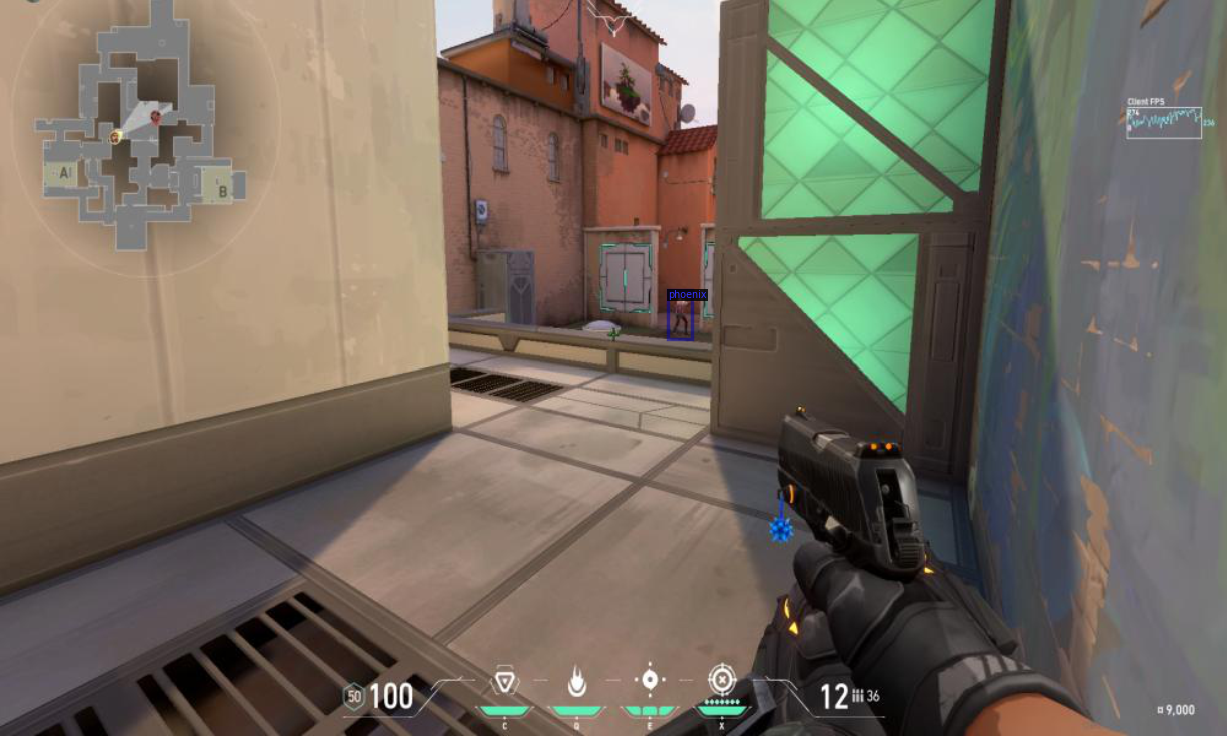

In [ ]:
# Making sure the custom dataset is correctly loaded

skip_first = 3 # skip the first k images in batch to visualize k+1th image

for i, x in enumerate(train_dl):
  if i in range(skip_first): continue
  print(x[0]['instances'])
  img = x[0]['image'].numpy().transpose(1, 2, 0)[:, :, ::-1]
  metadata = MetadataCatalog.get(train_valorant_dataset)
  v = Visualizer(img, metadata) # Defining visualizer with image
  target_fields = x[0]["instances"].get_fields()
  labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]] # Mapping class indices to class names for labels
  vis = v.overlay_instances(  # Creating VisImage made from visualizer with boxes
      labels=labels,
      boxes=target_fields.get("gt_boxes", None),
      )
  cv2_imshow(vis.get_image()[:, :, ::-1])
  break

In [ ]:
# Build model from cfg and save the .pth file using a Checkpointer

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)

DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)  # load a file, usually from cfg.MODEL.WEIGHTS
checkpointer = DetectionCheckpointer(model, save_dir="./")
checkpointer.save("base_detection_model")

[04/26 03:57:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from http://dl.yf.io/fs-det/models/voc/split1/base_model/model_final.pth ...
[04/26 03:57:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from http://dl.yf.io/fs-det/models/voc/split1/base_model/model_final.pth ...
[04/26 03:57:56 fvcore.common.checkpoint]: [Checkpointer] Loading from /root/.torch/iopath_cache/fs-det/models/voc/split1/base_model/model_final.pth ...
[04/26 03:57:57 fvcore.common.checkpoint]: Saving checkpoint to ./base_detection_model.pth


In [ ]:
del im

# Novel Weights Initialization

In [ ]:
# Making base model with fresh final layer

!python3 -m tools.ckpt_surgery \
        --src1 ./base_detection_model.pth \
        --method remove \
        --save-dir ./

# save changed ckpt to ./model_reset_remove.pth

save changed ckpt to ./model_reset_remove.pth


In [ ]:
!python3 -m tools.train_net --num-gpus 1 \
        --config-file configs/fsod-valorant-detection/valorant-train.yaml \
        --opts MODEL.WEIGHTS ./model_reset_remove.pth

Command Line Args: Namespace(config_file='configs/fsod-valorant-detection/valorant-train.yaml', resume=False, eval_only=False, eval_all=False, eval_during_train=False, eval_iter=-1, start_iter=-1, end_iter=-1, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', './model_reset_remove.pth'])
[04/26 04:40:01 detectron2]: Rank of current process: 0. World size: 1
[04/26 04:40:01 detectron2]: Command line arguments: Namespace(config_file='configs/fsod-valorant-detection/valorant-train.yaml', resume=False, eval_only=False, eval_all=False, eval_during_train=False, eval_iter=-1, start_iter=-1, end_iter=-1, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', './model_reset_remove.pth'])
[04/26 04:40:01 detectron2]: Contents of args.config_file=configs/fsod-valorant-detection/valorant-train.yaml:
_BASE_: "../Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "./model_reset_surgery.pth"
  MASK_ON: False
  RESNETS

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

# (Start of Old) Randinit initialization 


In [ ]:
#@title
# Making base model with fresh final layer

# Randomly initialize final layer weights 
# Saved as ./model_reset_surgery.pth
!python3 -m tools.ckpt_surgery \
        --src1 ./base_detection_model.pth \
        --method randinit \
        --save-dir ./

# New model with randomly initialized final layer (with the 20 VOC classes)
# Making config
cfg_ri = get_cfg()
cfg_ri.merge_from_file(config_file_name)
cfg_ri.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
cfg_ri.MODEL.DEVICE = DEVICE
cfg_ri.MODEL.WEIGHTS = "./model_reset_surgery.pth"
predictor_ri = DefaultPredictor(cfg_ri)
outputs_ri = predictor_ri(im)

save changed ckpt to ./model_reset_surgery.pth
[04/24 23:18:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_reset_surgery.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


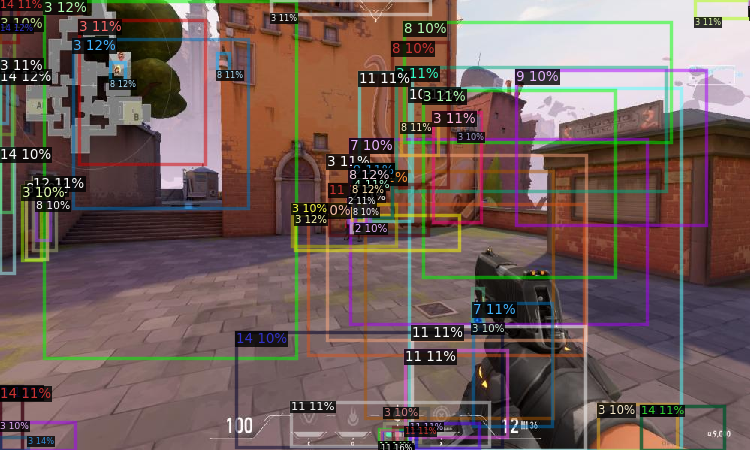

In [ ]:
#@title
# # Getting outputs on model with random initialization on final layer (should suck)
# # print(outputs_ri["instances"].pred_classes)
# # print(outputs_ri["instances"].pred_boxes)
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.75)
# out = v.draw_instance_predictions(outputs_ri["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#@title
# Begin fine-tuning training stage on custom Valorant dataset
#0.01 lr
!python3 -m tools.train_net --num-gpus 1 \
       --config-file configs/fsod-valorant-detection/faster_rcnn_R_101_FPN_ft_fc_all1_10shot.yaml \
        --opts MODEL.WEIGHTS ./model_reset_surgery.pth

Command Line Args: Namespace(config_file='configs/fsod-valorant-detection/faster_rcnn_R_101_FPN_ft_fc_all1_10shot.yaml', resume=False, eval_only=False, eval_all=False, eval_during_train=False, eval_iter=-1, start_iter=-1, end_iter=-1, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', './model_reset_surgery.pth'])
[04/24 23:18:49 detectron2]: Rank of current process: 0. World size: 1
[04/24 23:18:49 detectron2]: Command line arguments: Namespace(config_file='configs/fsod-valorant-detection/faster_rcnn_R_101_FPN_ft_fc_all1_10shot.yaml', resume=False, eval_only=False, eval_all=False, eval_during_train=False, eval_iter=-1, start_iter=-1, end_iter=-1, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', './model_reset_surgery.pth'])
[04/24 23:18:49 detectron2]: Contents of args.config_file=configs/fsod-valorant-detection/faster_rcnn_R_101_FPN_ft_fc_all1_10shot.yaml:
_BASE_: "../Base-RCNN-FPN.y

# (End of Old)

In [ ]:
# Evaluate the model

!python3 -m tools.test_net --num-gpus 1 \
        --config-file configs/fsod-valorant-detection/valorant-test.yaml \
        --eval-only \
        --opts MODEL.WEIGHTS /content/gdrive/MyDrive/11785/11785-project/model_final.pth

Traceback (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/content/fsod-valorant/tools/test_net.py", line 27, in <module>
    from fsdet.engine import DefaultTrainer, default_argument_parser, default_setup
  File "/content/fsod-valorant/fsdet/engine/__init__.py", line 1, in <module>
    import fsdet.data.builtin as _UNUSED  # register datasets
  File "/content/fsod-valorant/fsdet/data/builtin.py", line 269, in <module>
    register_all_pascal_voc()
  File "/content/fsod-valorant/fsdet/data/builtin.py", line 254, in register_all_pascal_voc
    register_meta_pascal_voc(
  File "/content/fsod-valorant/fsdet/data/meta_pascal_voc.py", line 152, in register_meta_pascal_voc
    MetadataCatalog.get(name).set(
  File "/usr/local/lib/python3.9/dist-packages/detectron2/data/catalog.py", line 167, in set
    setattr(self, k, v)
  File "/usr/local/lib/pytho

In [ ]:
#ft_config_file_name = config_file_name
#print(config_file_name)
ft_config_file_name = "configs/fsod-valorant-detection/valorant-test.yaml"

cfg_ft = get_cfg()
cfg_ft.merge_from_file(ft_config_file_name)
cfg_ft.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15  # set threshold for this model
cfg_ft.MODEL.DEVICE = DEVICE
cfg_ft.MODEL.WEIGHTS = "./checkpoints/model_final.pth"

# "/content/gdrive/MyDrive/11785/11785-project/model_final.pth"

configs/PascalVOC-detection/split1/faster_rcnn_R_101_FPN_base1.yaml


Instances(num_instances=1, image_height=608, image_width=1013, fields=[gt_boxes: Boxes(tensor([[325.1730, 133.7600, 351.5110, 188.9867]])), gt_classes: tensor([5])])
[04/25 07:18:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/gdrive/MyDrive/11785/11785-project/model_final.pth ...


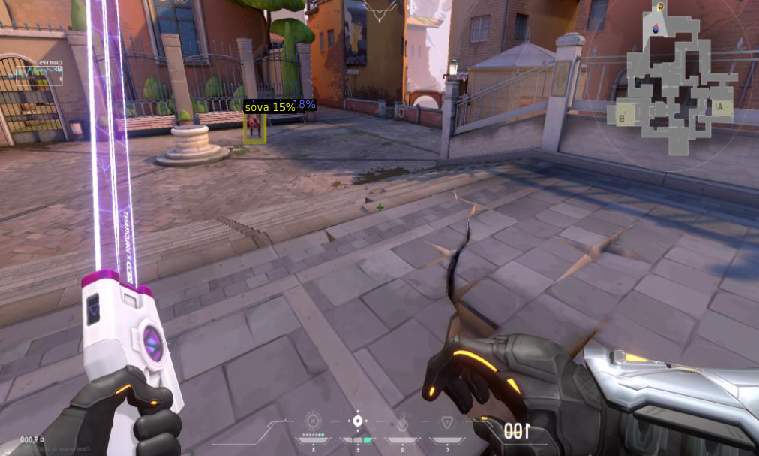

In [ ]:
# Visualizing results of model fine-tuned on custom Valorant data versus ground truth

skip_first = 4 # skip the first k images in batch to see results on k+1th image
img = None
for i, x in enumerate(valid_dl):
  if i in range(skip_first): continue
  #print(x[0].keys())
  img = x[0]['image'].numpy().transpose(1, 2, 0)[:, :, ::-1]
  break

predictor_ft = DefaultPredictor(cfg_ft)
outputs_ft = predictor_ft(img)

# print(outputs_ft["instances"].pred_classes)
# print(outputs_ft["instances"].pred_boxes)
#print(outputs_ft['instances'])

# Finding highest confidence classification
#print(outputs_ft['instances'].scores)
if len(outputs_ft['instances'].scores) > 0:
  best_class_index = torch.argmax(outputs_ft['instances'].scores)
  best_confidence = outputs_ft['instances'].scores[best_class_index]
  best_class_id = outputs_ft['instances'].pred_classes[best_class_index]
  metadata = MetadataCatalog.get(valid_valorant_dataset)
  best_class = metadata.thing_classes[best_class_id]
  print("------------")
  print("Highest Confidence Classification:", best_class)
  print("Confidence:", best_confidence)
  print("------------")

v = Visualizer(img, MetadataCatalog.get(cfg_ft.DATASETS.TRAIN[0]), scale=0.75)
out = v.draw_instance_predictions(outputs_ft["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

#ground truth
for i, x in enumerate(valid_dl):
  if i in range(skip_first): continue
  #print(x[0]['instances'])
  #print(x[0])
  img = x[0]['image'].numpy().transpose(1, 2, 0)[:, :, ::-1]
  metadata = MetadataCatalog.get(valid_valorant_dataset)
  v = Visualizer(img, metadata, scale=0.75) # Defining visualizer with image
  target_fields = x[0]["instances"].get_fields()
  labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]] # Mapping class indices to class names for labels
  vis = v.overlay_instances(  # Creating VisImage made from visualizer with boxes
      labels=labels,
      boxes=target_fields.get("gt_boxes", None),
      )
  cv2_imshow(vis.get_image()[:, :, ::-1])
  break

# Model Code Structure Study

In [ ]:
%pwd
%cd fsod-valorant/

/content/fsod-valorant


In [ ]:
import sys
sys.path.append('.')
import tools.train_net
from fsdet.config import get_cfg, set_global_cfg
from fsdet.engine import DefaultTrainer, default_argument_parser, default_setup
# train_net.setup
import argparse

# create an empty Namespace object
args = argparse.Namespace()

# add attributes to the Namespace object
args.config_file = '/content/fsod-valorant/configs/fsod-valorant-detection/valorant-train.yaml'
args.opts = ''
cfg = tools.train_net.setup(args)

trainer = DefaultTrainer(cfg)
m_ = trainer.build_model(cfg)
print(m_)
optimizer = trainer.build_optimizer(cfg, m_)
print(optimizer)

[04/26 04:07:41 detectron2]: Rank of current process: 0. World size: 1
[04/26 04:07:41 detectron2]: Rank of current process: 0. World size: 1
[04/26 04:07:41 detectron2]: Command line arguments: Namespace(config_file='/content/fsod-valorant/configs/fsod-valorant-detection/valorant-train.yaml', opts='')
[04/26 04:07:41 detectron2]: Command line arguments: Namespace(config_file='/content/fsod-valorant/configs/fsod-valorant-detection/valorant-train.yaml', opts='')
[04/26 04:07:41 detectron2]: Contents of args.config_file=/content/fsod-valorant/configs/fsod-valorant-detection/valorant-train.yaml:
_BASE_: "../Base-RCNN-FPN.yaml"
MODEL:
  WEIGHTS: "./model_reset_surgery.pth"
  MASK_ON: False
  RESNETS:
    DEPTH: 101
  ROI_HEADS:
    NUM_CLASSES: 11
    FREEZE_FEAT: False
  BACKBONE:
    FREEZE: False
  PROPOSAL_GENERATOR:
    FREEZE: True
INPUT:
  MIN_SIZE_TRAIN: (480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800)
  MIN_SIZE_TEST: 800
DATASETS:
  TRAIN: ('fsod-valorant-4-train',)
  TEST

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


froze proposal generator parameters
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

In [ ]:
layer_names = []
for idx, (name, param) in enumerate(m_.named_parameters()):
    layer_names.append(name)
    print(f'{idx}: {name} {param.requires_grad}')

0: backbone.fpn_lateral2.weight False
1: backbone.fpn_lateral2.bias False
2: backbone.fpn_output2.weight False
3: backbone.fpn_output2.bias False
4: backbone.fpn_lateral3.weight False
5: backbone.fpn_lateral3.bias False
6: backbone.fpn_output3.weight False
7: backbone.fpn_output3.bias False
8: backbone.fpn_lateral4.weight False
9: backbone.fpn_lateral4.bias False
10: backbone.fpn_output4.weight False
11: backbone.fpn_output4.bias False
12: backbone.fpn_lateral5.weight False
13: backbone.fpn_lateral5.bias False
14: backbone.fpn_output5.weight False
15: backbone.fpn_output5.bias False
16: backbone.bottom_up.stem.conv1.weight False
17: backbone.bottom_up.res2.0.shortcut.weight False
18: backbone.bottom_up.res2.0.conv1.weight False
19: backbone.bottom_up.res2.0.conv2.weight False
20: backbone.bottom_up.res2.0.conv3.weight False
21: backbone.bottom_up.res2.1.conv1.weight False
22: backbone.bottom_up.res2.1.conv2.weight False
23: backbone.bottom_up.res2.1.conv3.weight False
24: backbone.bott

In [ ]:
#layer_names.reverse()
lr      = 0.001
lr_mult = 0.5
decay_num = 10
# placeholder
parameters      = []
prev_group_name = layer_names[-1].split('.')[-2]
# store params & learning rates
for name in layer_names[::-1]:
    #print(name)
    # # parameter group name
    cur_group_name = name.split('.')[-2]
    #print(cur_group_name)
    # # update learning rate
    if cur_group_name != prev_group_name:
        lr *= lr_mult
        decay_num -=1
    prev_group_name = cur_group_name
    
    # # display info
    print(f'lr = {lr}, {name}')
    
    # # append layer parameters # order problem !!
    parameters.append({'params': [p for n, p in m_.named_parameters() if n == name ],
                    'lr':     lr,
                    'dampening': 0,
                    'momentum': 0.9,
                    'weight_decay': 0.0001,
                    'foreach': True})
    if decay_num <= 0: break
print(parameters)

NameError: ignored

In [ ]:
optimizer = torch.optim.SGD(parameters)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 2
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.0005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 3
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.0005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 4
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.00025
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001

Parameter Group 5
    dampening: 0
    differentiable: False
    foreach: True
    lr: 0.00025
    maximi

In [ ]:
for name, param in m_.named_parameters():
    #print(param)
    for param_group in optimizer.param_groups:
        #print(param_group['params'])
        if param == param_group['params']:
            #print(f"Layer Name: {name}, Learning Rate: {param_group['lr']}")
            break